In [1]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [2]:
import pandas as pd
import numpy as np
import gzip
import json
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import string
from nltk.corpus import stopwords
import spacy
from wordcloud import WordCloud
# initialize the analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,f1_score,confusion_matrix,plot_confusion_matrix
from scipy.sparse import hstack,csr_matrix
from tqdm import tqdm
import operator

In [4]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield json.loads(l)

In [5]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

In [6]:
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [7]:
df = getDF('Grocery_and_Gourmet_Food_5.json.gz')

In [8]:
print(f"Data dimension: {df.shape}")
for col in df.columns:
    print(f"Column: {col:35} | type: {str(df[col].dtype):7} \
| missing values: {df[col].isna().sum():3d}")

Data dimension: (1143860, 12)
Column: overall                             | type: float64 | missing values:   0
Column: verified                            | type: bool    | missing values:   0
Column: reviewTime                          | type: object  | missing values:   0
Column: reviewerID                          | type: object  | missing values:   0
Column: asin                                | type: object  | missing values:   0
Column: reviewerName                        | type: object  | missing values: 138
Column: reviewText                          | type: object  | missing values: 390
Column: summary                             | type: object  | missing values: 219
Column: unixReviewTime                      | type: int64   | missing values:   0
Column: vote                                | type: object  | missing values: 985658
Column: style                               | type: object  | missing values: 551774
Column: image                               | type: object  | 

In [9]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN
1,5.0,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN
2,5.0,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,1448064000,NaN,NaN,NaN
3,5.0,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,1439337600,NaN,NaN,NaN
4,5.0,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,1432771200,NaN,NaN,NaN


In [10]:
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'],unit='s')

In [11]:
df.overall.value_counts(dropna=False)

5.0    820387
4.0    150771
3.0     80706
1.0     49864
2.0     42132
Name: overall, dtype: int64

In [12]:
df.verified.value_counts(dropna=False)

True     993847
False    150013
Name: verified, dtype: int64

In [13]:
df.asin.value_counts(dropna=False)

B00BUKL666    7387
B008QMX2SG    6228
B00D3M2QP4    6221
B00R7PWK7W    3387
B000X3TPHS    3030
              ... 
B000MAOW20       1
B000YINEYW       1
B0011MQSSY       1
B0012TCW1S       1
B000WW6VZO       1
Name: asin, Length: 41320, dtype: int64

In [14]:
df = df.drop(['image', 'style', 'vote', 'reviewTime'], axis = 1)

Text(0, 0.5, 'Count')

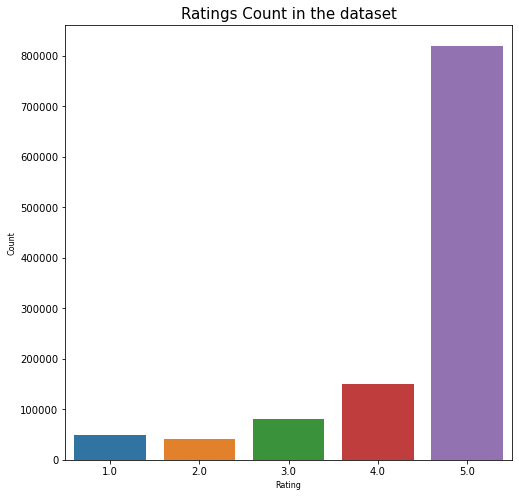

In [15]:
plt.figure(figsize=(8,8))
sns.countplot(df['overall'])
plt.title('Ratings Count in the dataset',fontsize=15)
plt.xlabel('Rating',fontsize=8)
plt.ylabel('Count',fontsize=8)

In [16]:
(df['overall'].value_counts()/df.shape[0])*100

5.0    71.720927
4.0    13.180896
3.0     7.055584
1.0     4.359275
2.0     3.683318
Name: overall, dtype: float64

In [17]:
(df['verified'].value_counts()/df.shape[0])*100

True     86.885371
False    13.114629
Name: verified, dtype: float64

In [18]:
df.groupby('verified')['overall'].value_counts(dropna=False,normalize=True)

verified  overall
False     5.0        0.609121
          4.0        0.172825
          3.0        0.089292
          1.0        0.076527
          2.0        0.052235
True      5.0        0.733524
          4.0        0.125618
          3.0        0.067728
          1.0        0.038622
          2.0        0.034508
Name: overall, dtype: float64

In [19]:
list(df['reviewText'])[:10]

['No adverse comment.',
 'Gift for college student.',
 'If you like strong tea, this is for you. It might even be a little too strong for me.',
 'Love the tea. The flavor is way better than the regular Lipton black tea. Definetly worth the money.',
 'I have searched everywhere until I browsed Amazon and found it!  This is the tea Lipton should be selling on grocery store shelves.  The stuff I last purchased is just awful, and nowhere near as good as I remember.',
 'Tea made with Lipton Yellow Label teabags is much better than tea made with regular Lipton teabags.',
 "I love this tea!  Okay, I'm not a high falutin' tea snob, but I first enjoyed this Lipton yellow label tea when on a trip to Singapore, and whether it was the room service, the company, or the country - it left such a favorable impression on me, I search it out whenever possible.  Maybe it's the same as the USA's white label Lipton tea, but the yellow label tea appears to me to be smoother and more mellow.  I would highly 

In [20]:
len(df)-len(df.dropna())

705

In [21]:
len(df)

1143860

In [22]:
df = df.dropna()

In [23]:
for i in range(0,len(df)-1):
    if type(df.iloc[i]['reviewText']) != str:
        products.iloc[i]['reviewText'] = str(products.iloc[i]['reviewText'])

In [24]:
df = df[df['overall'] != 3]

In [25]:
def sentiment(n):
    return 1 if n >= 4 else 0

In [26]:
df['sentiment'] = df['overall'].apply(sentiment)
df.head()

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,sentiment
0,5.0,True,A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,2014-11-19,1
1,5.0,True,A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,2016-10-13,1
2,5.0,True,A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,2015-11-21,1
3,5.0,True,A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,2015-08-12,1
4,5.0,True,A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,2015-05-28,1


In [27]:
def combined_features(row):
    return row['summary'] + ' '+ row['reviewText']

In [28]:
df['all_features'] = df.apply(combined_features, axis=1)

In [29]:
df.head()

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,sentiment,all_features
0,5.0,True,A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,2014-11-19,1,Five Stars No adverse comment.
1,5.0,True,A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,2016-10-13,1,Great product. Gift for college student.
2,5.0,True,A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,2015-11-21,1,"Strong If you like strong tea, this is for you..."
3,5.0,True,A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,2015-08-12,1,Great tea Love the tea. The flavor is way bett...
4,5.0,True,A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,2015-05-28,1,This is the tea I remembered! I have searched ...


In [30]:
X = df['all_features']
y = df['sentiment']

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
ctmTr = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression()
model.fit(ctmTr, y_train)

LogisticRegression()

In [36]:
y_pred_class = model.predict(X_test_dtm)

In [37]:
accuracy_score(y_test, y_pred_class)

0.9698135654478646